Este cuaderno contiene un primer tutorial rápido y sencillo de cómo usar el modelo scGPT, sin hacer fine-tuning, para la tarea de Cell type annotation. Por medio de este código, pude obtener los primeros embeddings usando una arquitectura Transformers. 

Los autores del tutorial explican que es para Cel type Annotation, la realidad es que solo nos permite obtener los embeddings. Toda la parte posterior de evaluación de la calidad de estos embeddings no sería posible tal y como ellos plantean el tutorial.

Para poder ejecutarlo deberás hacerlo a través de una máquina con sistema operativo Linux y preferiblemente una GPU Nvidia, aunque también se podría ejecutar en una CPU medio potente.

In [1]:
# Import libraries

import warnings
import urllib.request
from pathlib import Path
import os

import torch
import scgpt as scg
import scanpy as sc
import numpy as np
import pandas as pd
import gdown


warnings.filterwarnings("ignore")

In [2]:
warnings.simplefilter("ignore", ResourceWarning)
warnings.filterwarnings("ignore", category=ImportWarning)

output_dir = "../Experimentacion/save/scGPT_human"
if os.path.exists(output_dir):
    print("model checkpoint already downloaded!!")
else:
    # Use gdown with the recursive flag to download the folder
    # Replace the folder ID with the ID of your folder
    folder_id = "1oWh_-ZRdhtoGQ2Fw24HP41FgLoomVo-y"
    # Download the folder and its contents recursively
    gdown.download_folder(f"https://drive.google.com/drive/folders/{folder_id}", output=output_dir, quiet=False)

model checkpoint already downloaded!!


In [3]:
# This code downloads the data temporarily
uri = "https://datasets.cellxgene.cziscience.com/f50deffa-43ae-4f12-85ed-33e45040a1fa.h5ad"
source_path = "../Experimentacion/data/source.h5ad"
urllib.request.urlretrieve(uri, filename=source_path)
adata = sc.read_h5ad(source_path)

batch_key = "sample"
N_HVG = 3000

"""
    Filtramos el dataset para obtener aquellos genes con una mayor variabilidad y que más
    info nos aportan
"""
sc.pp.highly_variable_genes(adata, n_top_genes=N_HVG, flavor='seurat_v3')
adata_hvg = adata[:, adata.var['highly_variable']]

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [8]:
adata_hvg

View of AnnData object with n_obs × n_vars = 11103 × 3000
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'cell_line', 'epcam_positive', 'vim_positive', 'condition_new', 'annotation_res0.34_new2', 'annotation_res0.34_simple2', 'compartment_new2', 'organism_ontology_term_id', 'tissue_ontology_term_id', 'tissue_type', 'assay_ontology_term_id', 'disease_ontology_term_id', 'cell_type_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'suspension_type', 'donor_id', 'is_primary_data', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'annotation

In [7]:
adata_hvg.var

,vst.mean,vst.variance,vst.variance.expected,vst.variance.standardized,vst.variable,feature_is_filtered,feature_name,feature_reference,feature_biotype,feature_length,highly_variable,highly_variable_rank,means,variances,variances_norm
ensemble,,,,,,,,,,,,,,,
ENSG00000177757,0.001657,0.001764,0.001811,0.974021,0,False,FAM87B,NCBITaxon:9606,gene,1947,True,1368.0,0.000524,0.000336,1.548999
ENSG00000187634,0.052457,0.238785,0.077645,3.075354,1,False,SAMD11,NCBITaxon:9606,gene,4172,True,987.0,0.013083,0.009766,1.713976
ENSG00000188290,0.553893,3.762157,0.945983,3.976981,1,False,HES4,NCBITaxon:9606,gene,1118,True,672.0,0.146175,0.108935,1.940047
ENSG00000205231,0.001380,0.001600,0.001500,1.066529,0,False,TTLL10-AS1,NCBITaxon:9606,gene,3532,True,874.0,0.000370,0.000254,1.776753
ENSG00000186891,0.002043,0.002812,0.002254,1.247330,0,False,TNFRSF18,NCBITaxon:9606,gene,1271,True,1575.0,0.000667,0.000389,1.489748
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000212907,5.742463,34.441153,31.108465,1.107131,0,False,MT-ND4L,NCBITaxon:9606,gene,297,True,1636.0,0.973165,0.335829,1.475150
ENSG00000198886,113.644948,9042.810150,8455.856540,1.069414,0,False,MT-ND4,NCBITaxon:9606,gene,1378,True,1574.0,3.546317,0.375128,1.489772
ENSG00000198786,34.738211,863.889771,837.550675,1.031448,0,False,MT-ND5,NCBITaxon:9606,gene,1812,True,1313.0,2.417865,0.417605,1.568644


In [5]:
#warnings.simplefilter("ignore", ResourceWarning)



model_dir = Path("/home/pablo/git/Transformers-Architecture-in-Bioinformatics/Experimentacion/save/scGPT_human")



gene_col = "feature_name"
cell_type_key = "cell_type"

ref_embed_adata = scg.tasks.embed_data(
    adata_hvg,
    model_dir,
    gene_col=gene_col,
    obs_to_save=cell_type_key,  # optional arg, only for saving metainfo
    batch_size=64,
    return_new_adata=True, #Si fuera false, simplemente añade los embeddings a adata_hvg.obms
)

scGPT - INFO - match 2660/3000 genes in vocabulary of size 60697.


Embedding cells: 100%|██████████| 174/174 [46:12<00:00, 15.93s/it]


Los embeddings generados se guardan en X y tienen una dimensión de 512

In [24]:
ref_embed_adata.X.shape

ref_embed_adata

AnnData object with n_obs × n_vars = 11103 × 512
    obs: 'cell_type'
    uns: 'neighbors', 'umap'
    obsm: 'X_umap'
    obsp: 'distances', 'connectivities'

In [7]:
sc.pp.neighbors(ref_embed_adata, use_rep="X")
sc.tl.umap(ref_embed_adata)

Ponemos tanto el umap calculado como los embeddings en el objeto AnnData original

In [8]:
adata.obsm["X_scgpt"] = ref_embed_adata.X
adata.obsm["X_umap"] = ref_embed_adata.obsm["X_umap"]


In [9]:
# Add the current index ('ensembl_id') as a new column
adata.var['ensembl_id'] = adata.var.index

# Set the new index to the 'feature_name' column
adata.var.set_index('feature_name', inplace=True)

In [10]:
# Add a copy of the gene symbols back to the var dataframe
adata.var['gene_symbol'] = adata.var.index

Antes que nada nos asegurarmos de guardar el objeto AnnData para no tener que repetir los cálculos de nuevo.

In [ ]:

adata.write("/Users/doblado/Transformers-Architecture-in-Bioinformatics/Experimentacion/embeddings_generated/first_get_started_embeddings.h5ad")

FileNotFoundError: [Errno 2] Unable to synchronously create file (unable to open file: name = '/Transformers-Architecture-in-Bioinformatics/Experimentacion/scGPT_embeddings/first_get_started_embeddings.h5ad', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 602)

In [13]:
adata_prueba = sc.read("/Users/doblado/Transformers-Architecture-in-Bioinformatics/Experimentacion/embeddings_generated/first_get_started_embeddings.h5ad")

adata_prueba

AnnData object with n_obs × n_vars = 11103 × 33118
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'cell_line', 'epcam_positive', 'vim_positive', 'condition_new', 'annotation_res0.34_new2', 'annotation_res0.34_simple2', 'compartment_new2', 'organism_ontology_term_id', 'tissue_ontology_term_id', 'tissue_type', 'assay_ontology_term_id', 'disease_ontology_term_id', 'cell_type_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'suspension_type', 'donor_id', 'is_primary_data', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'feature_is_filtered', 'feature_reference', 'feature_biotype', 'feature_length', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'ensembl_id', 'gene_symbol'
    uns: 'anno

In [22]:
adata_prueba.obs.head()

,nCount_RNA,nFeature_RNA,percent.mt,cell_line,epcam_positive,vim_positive,condition_new,annotation_res0.34_new2,annotation_res0.34_simple2,compartment_new2,organism_ontology_term_id,tissue_ontology_term_id,tissue_type,assay_ontology_term_id,disease_ontology_term_id,cell_type_ontology_term_id,self_reported_ethnicity_ontology_term_id,development_stage_ontology_term_id,sex_ontology_term_id,suspension_type,donor_id,is_primary_data,cell_type,assay,disease,organism,sex,tissue,self_reported_ethnicity,development_stage,observation_joinid
AAACCCAAGGGTAATT_1,20005.0,4834,4.718820,IoC_donor2,1,0,EM-DM,Enterocyte type 1,Enterocyte,Epithelial cell,NCBITaxon:9606,UBERON:0001242,organoid,EFO:0009922,PATO:0000461,CL:0000584,HANCESTRO:0005,HsapDv:0000120,PATO:0000383,cell,IoC_donor2,True,enterocyte,10x 3' v3,normal,Homo sapiens,female,intestinal mucosa,European,26-year-old human stage,Quks82Lel}
AAACGAAAGTTTGCTG_1,14923.0,3713,2.030423,IoC_donor2,1,0,EM-DM,Paneth-like cell,Paneth-like cell,Epithelial cell,NCBITaxon:9606,UBERON:0001242,organoid,EFO:0009922,PATO:0000461,CL:0000510,HANCESTRO:0005,HsapDv:0000120,PATO:0000383,cell,IoC_donor2,True,paneth cell,10x 3' v3,normal,Homo sapiens,female,intestinal mucosa,European,26-year-old human stage,Yl2k;v`{ks
AAACGCTGTTCTTAGG_1,11852.0,3290,2.953088,IoC_donor2,1,0,EM-DM,Paneth-like cell,Paneth-like cell,Epithelial cell,NCBITaxon:9606,UBERON:0001242,organoid,EFO:0009922,PATO:0000461,CL:0000510,HANCESTRO:0005,HsapDv:0000120,PATO:0000383,cell,IoC_donor2,True,paneth cell,10x 3' v3,normal,Homo sapiens,female,intestinal mucosa,European,26-year-old human stage,md;quWf0?r
AAACGCTGTTCTTGTT_1,12730.0,4682,4.870385,IoC_donor2,1,0,EM-DM,Enteroendocrine cell,Enteroendocrine cell,Epithelial cell,NCBITaxon:9606,UBERON:0001242,organoid,EFO:0009922,PATO:0000461,CL:0000164,HANCESTRO:0005,HsapDv:0000120,PATO:0000383,cell,IoC_donor2,True,enteroendocrine cell,10x 3' v3,normal,Homo sapiens,female,intestinal mucosa,European,26-year-old human stage,sy7u>Vox}I
AAACGCTTCCGATCGG_1,29021.0,5127,5.609731,IoC_donor2,1,0,EM-DM,Enterocyte type 1,Enterocyte,Epithelial cell,NCBITaxon:9606,UBERON:0001242,organoid,EFO:0009922,PATO:0000461,CL:0000584,HANCESTRO:0005,HsapDv:0000120,PATO:0000383,cell,IoC_donor2,True,enterocyte,10x 3' v3,normal,Homo sapiens,female,intestinal mucosa,European,26-year-old human stage,>@Wfy8=79{


In [13]:
output_umap = "genEmbeddings_figures"
os.makedirs(output_umap, exist_ok=True)
sc.settings.figdir = output_umap

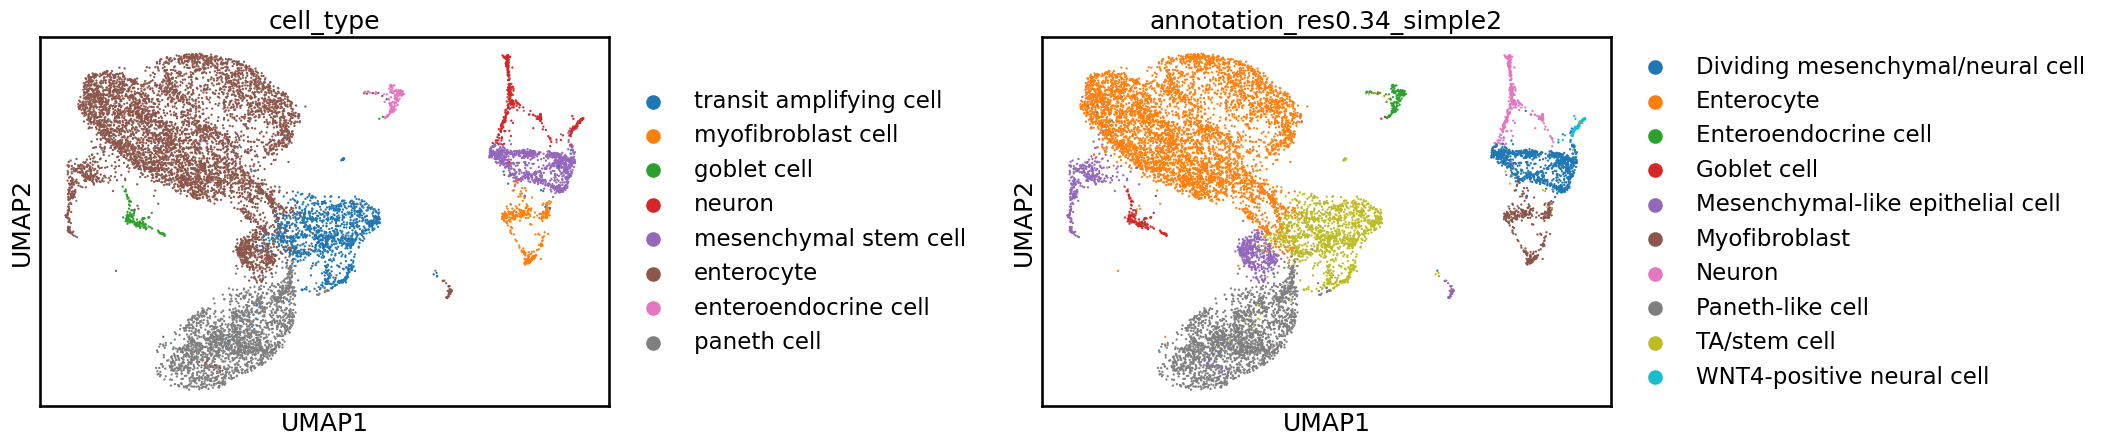

In [ ]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    #sc.pp.neighbors(ref_embed_adata, use_rep="X")
    #sc.tl.umap(ref_embed_adata)
    sc.pl.umap(adata, color=["cell_type", "annotation_res0.34_new2"], wspace = 0.6, save="get_started_umap.png")

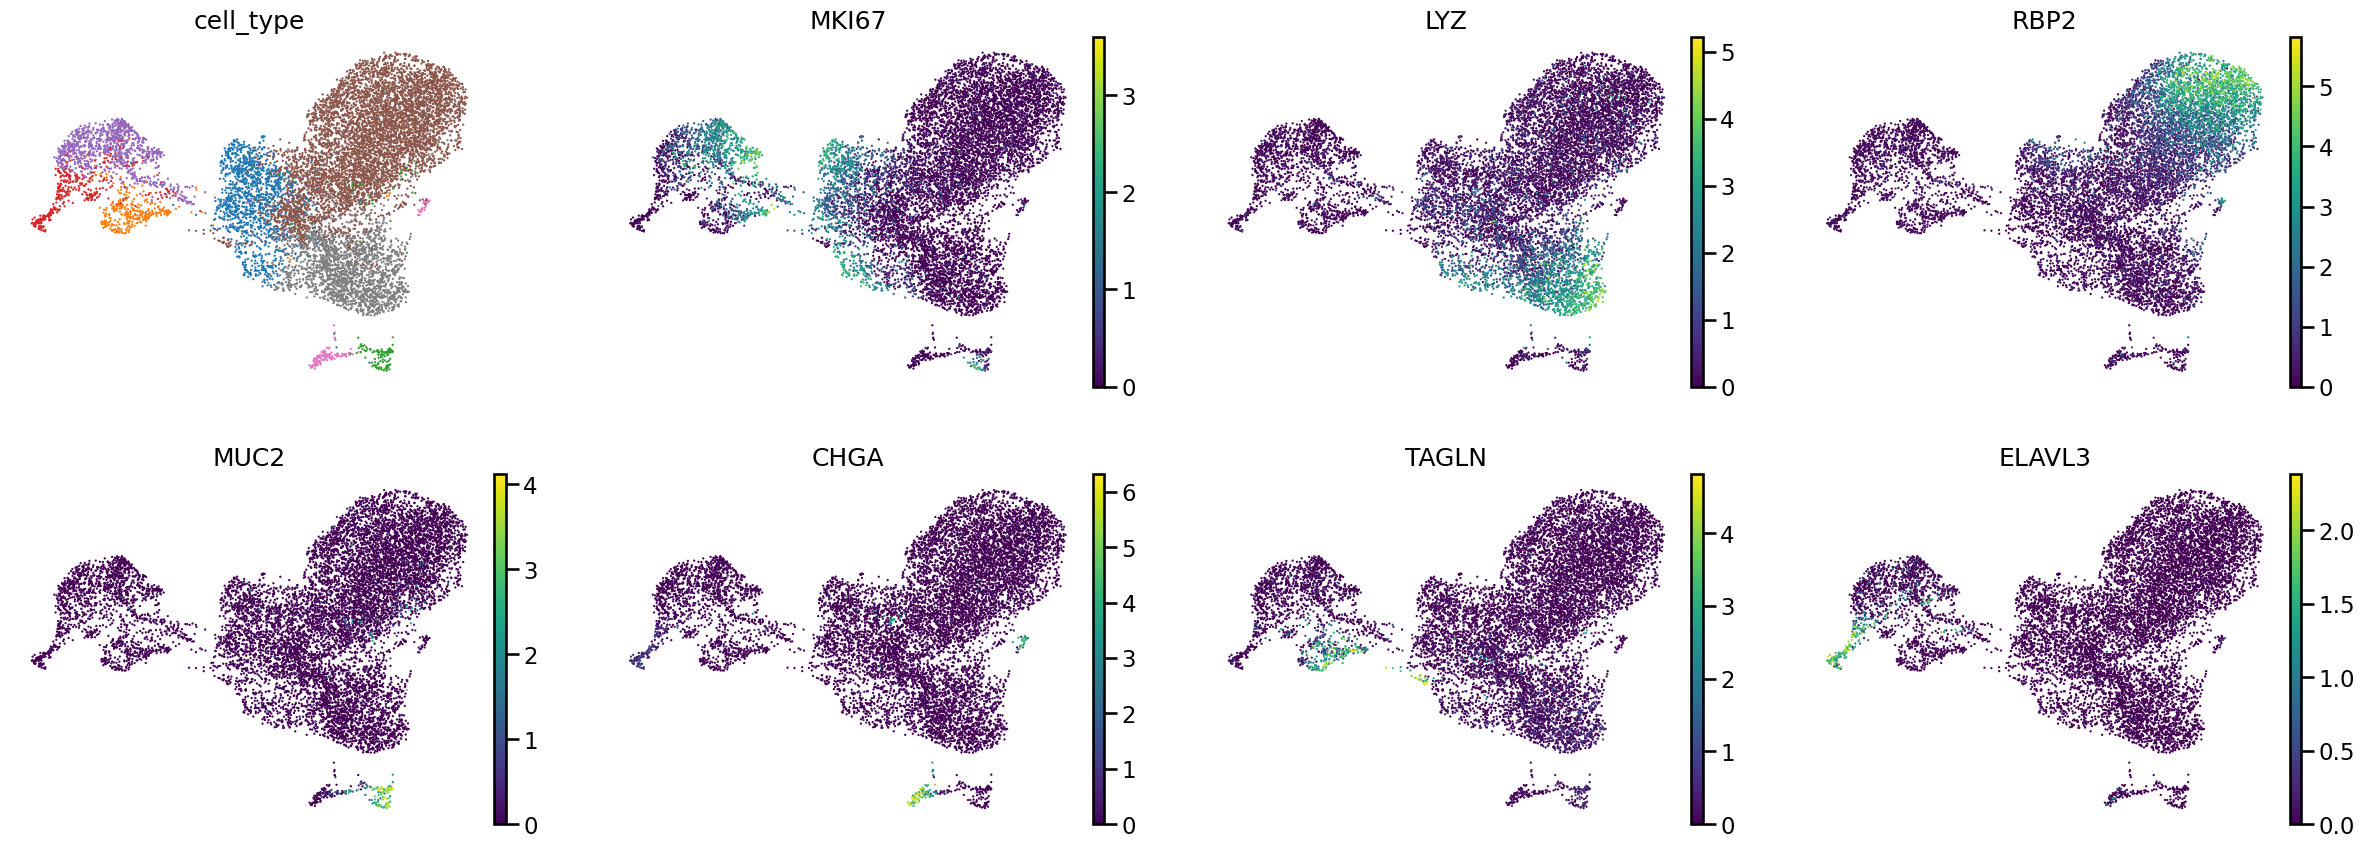

In [15]:
sc.pl.umap(adata, color=['cell_type', 'MKI67', 'LYZ', 'RBP2', 'MUC2', 'CHGA', 'TAGLN', 'ELAVL3'], frameon=False, use_raw=False, legend_fontsize ="xx-small", legend_loc="none", save="get_started_markers.png")